# Riemann problem for Euler equations with the Tammann EOS
We consider the one dimensional Riemann problem for the Euler equations with the Tammann EOS. The Tammann EOS, also known as stiffened gas EOS, is used to model almost incompressible fluids. It can be physically understood as modeling an ideal gas under very high ambient pressures. The Riemann problem we want to solve consists of the one dimensional Euler equations,

$$
\begin{align*}
    \left[\begin{array}{c} \rho \\   \rho u \\    E   \end{array} \right]_t +
    \left[\begin{array}{c} \rho u \\   \rho u^2 + p \\     u(E+p)   \end{array} \right]_x
=   0,
\end{align*}
$$

where $\rho$ is density, $u$ velocity, $E$ the internal energy and $p$ the pressure and the subcripts $x,t$ denote partial derivatives with respect $x$ and $t$. The Tamann EOS is given by 

$$
p=\rho e(\gamma -1) - \gamma p_{\infty},
$$

where $e$ the specific internal energy and $k =l,r$ determines which coefficients to use for the EOS. The initial conditions are given by the left and right constant states $q_l=[\rho_l, \rho_l u_l, E_l]$ and $q_r=[\rho_r, \rho_r u_r, E_r]$. Note that using the equation of state, the state of the system can also be written on the primitive variables $[\rho, u, p]$. 

## Exact solution

The exact solution to the Riemann problem with a Tammann EOS can be found in <cite data-cite="Ivings1998"><a href="riemann.html#Ivings1998">(Ivings & Toro 1998)<a></cite>. In the supplemental material of the work <cite data-cite="delrazo2017"><a href="riemann.html#delrazo2017">(del Razo, 2017)<a></cite>, the reader can find an extension of the analytic solution to the case where the parameters $\gamma$ and $p_\infty$ in the Tammann EOS have a discontinuity. In the following sections, we will focus in the latter since it is a more general case. Although we will not provide here the full derivation of the exact Riemann solver, we will give the outline of how we can solve it.

As we know from the previous examples, the solution of the Euler equations will consist of three waves: the 1-wave and 3-wave (rarefactions or shocks), and a 2-wave in between given by a contact discontinuity. The system will have four different solution states, $q_l,q_{*l},q_{*r},q_r$ separated by the three waves. In order to figure out if the 1-wave and 3-wave are rarefactions or shocks, we will need to create a function of the 
middle state pressure $p_*$ that ensures that the velocity $u_*$ across the contact discontinuity is consistent. As we know the velocity on the left state $u_l$ should be connected by a rarefaction or shock to $u_*$, we can 
calculate $u_*=u_l + [u]_1$ with $[u]_1$ the jump of the velocity across the 1-wave. In a similar manner, we also 
know the 3-wave should be a shock or rarefaction, so we can calculate $u_*= u_r - [u]_3$; therefore, it is useful to define

$$
\begin{align*}
  \phi_l(p_*) = u_* = u_l - \mathcal{F}_l(p_*), \\
  \phi_r(p_*) = u_* = u_r + \mathcal{F}_r(p_*).
\end{align*}
$$

where $\mathcal{F}_{l,r}(p_*) = -[u]_{1,3}$ will change form depending if it's a shock or a rarefaction (signs were 
chosen for notation consistency). As we expect these two equations yield the same contact discontinuity 
velocity $u_*$, then 

$$
\begin{align*}
 \Phi(p_*)= \phi_r(p_*) - \phi_l(p_*) = 0.
\end{align*}
$$

This nonlinear equation for $p_*$ will yield the pressure $p_*$ that provides consistency between the type of waves (rarefactions or shocks), their speeds and the contact discontinuity velocity $u_*$. As we mentioned before, the shape of $\phi_k(p_*)$ will depend on whether the states are connected by a shock wave or rarefaction. Once 
the $p_*$ has been found, the contact discontinuity velocity can be found from the expressions just derived. However, it is not yet clear how to calculate the density or the speeds of the 1-wave 
and 3-wave. How to obtain these quantities becomes obvious once we write the explicit equations for our system. The reader is referred to the supplemental material of <cite data-cite="delrazo2017"><a href="riemann.html#delrazo2017">(del Razo, 2017)<a></cite> for details in the explicit formulas.

Before coding the exact solution, we should first note that having a rarefaction or shock in the 1-wave 
and 3-wave will depend on the pressure $p_*$. How can we know which one, can be answered by simple physical 
intuition. If the pressure is higher on the side toward which the wave is propagating, it will yield a rarefaction. If the pressure is lower, it will be a shock. In the Euler equations, this yields four possible cases for the value $\Phi(p_*)$, just as in the solution with an ideal gas EOS:

 * 1-rarefaction, 3-rarefaction: $p_*< p_l$ and $p_*<p_r$  
 $\Phi(p_*)= \phi_r^R(p_*) - \phi_l^R(p_*)$,
 * 1-shock,       3-rarefaction $p_l \le p_* \le p_r$  
 $\Phi(p_*)= \phi_r^R(p_*) - \phi_l^S(p_*)$,
 * 1-rarefaction,       3-shock $p_r \le p_* \le p_l$  
 $\Phi(p_*)= \phi_r^S(p_*) - \phi_l^R(p_*)$,
 * 1-shock, 3-shock: $p_* > p_l$ and $p_*>p_r$  
 $\Phi(p_*)= \phi_r^S(p_*) - \phi_l^S(p_*)$,

where the index $S,R$ indicates if the $\phi$ was obtained by using the Rankine-Hugoniot equations to connect 
states by shocks or the Riemann invariants to connect them by rarefactions respectively.

The functions $\phi_{k}^{\mu}$ are derived in supplemental material of <cite data-cite="delrazo2017"><a href="riemann.html#delrazo2017">(del Razo, 2017)<a></cite> for all the four cases with $k=l,r$ and $\mu=R,S$, and it is also shown how to obtain the density and the missing wave speeds. For reference into the code, we denote the speed of the 1-wave, $s_l$, the 2-wave, $s_*$, and the 3-wave $s_r$.

With this, we now provide the code of the function $\Phi(p_*)$ as a function of $p_*$, the initial left and right states and the paramter values of the Tammann EOS on each side:

In [2]:
# %load exact_solvers/euler_tammann.py
import numpy as np
from scipy.optimize import fsolve
from utils import riemann_tools

conserved_variables = ('Density', 'Momentum', 'Energy')
primitive_variables = ('Density', 'Velocity', 'Pressure')


def primitive_to_conservative(rho, u, p, gamma, pinf):
    mom = rho*u
    E   = (p - gamma * pinf)/(gamma-1.) + 0.5*rho*u**2
    return rho, mom, E


def conservative_to_primitive(rho, mom, E, gamma, pinf):
    u = mom/rho
    p = (gamma-1.)*(E - 0.5*rho*u**2) - gamma*pinf
    return rho, u, p


def exact_riemann_solution(ql, qr, gamma, pinf, varin = 'primitive', varout = 'primitive'):
    
    # Get intial data
    gammal, gammar = gamma
    pinfl, pinfr = pinf
    if varin == 'conservative':
    	rhol, ul, pl = conservative_to_primitive(*ql, gamma = gammal, pinf = pinfl)
    	rhor, ur, pr = conservative_to_primitive(*qr, gamma = gammar, pinf = pinfr)
    else: 
    	rhol, ul, pl = ql
    	rhor, ur, pr = qr

    # Bar pressure (convenient change of variable)
    pbl = pl + pinfl
    pbr = pr + pinfr

    # Useful parameters
    gl1 = gammal - 1.0
    gr1 = gammar - 1.0
    bl = (gammal + 1.0)/(gammal - 1.0)
    br = (gammar + 1.0)/(gammar - 1.0)
    betal = pbl/bl
    betar = pbr/br
    al = 2.0/((gammal + 1.0)*rhol)
    ar = 2.0/((gammar + 1.0)*rhor
             )
    # Calculate velocities (sound speed)
    cl =  np.sqrt(gammal*(pl + pinfl)/rhol)
    cr =  np.sqrt(gammar*(pr + pinfr)/rhor)
    
    # Functions to calculate integral curves (rarefactions) and hugoniot locii (shocks)
    integral_curve_1 = lambda p : ul + 2*cl/gl1*(1 - ((p + pinfl)/pbl)**(gl1/(2.0*gammal)))
    integral_curve_3 = lambda p : ur - 2*cr/gr1*(1 - ((p + pinfr)/pbr)**(gr1/(2.0*gammar)))
    hugoniot_locus_1 = lambda p : ul - (p - pl)*np.sqrt(al/(p + pinfl + betal))
    hugoniot_locus_3 = lambda p : ur + (p - pr)*np.sqrt(ar/(p + pinfr + betar))
    
    # Check whether the 1-wave is a shock or rarefaction
    def phi_l(p):
        global wave1
        if p >= pl: # 1-Shock
            wave1 = 'shock' 
            return hugoniot_locus_1(p)
        else: # 1-Rarefaction
            wave1 = 'rarefaction'
            return integral_curve_1(p)

    # Check whether the 3-wave is a shock or rarefaction
    def phi_r(p):
        global wave3
        if p >= pr: 
            wave3 = 'shock'
            return hugoniot_locus_3(p)
        else: 
            wave3 = 'rarefaction'
            return integral_curve_3(p)
    
    phi = lambda p : phi_l(p) - phi_r(p)
    
  
    
    # Use fsolve to find p_star such that Phi(p_star)=0
    p0 = (pl + pr)/2.0 # initial guess is the average of initial pressures
    p_star, info, ier, msg = fsolve(phi, p0, full_output=True, xtol=1.e-14)
    # For strong rarefactions, sometimes fsolve needs help
    if ier != 1:
        p_star, info, ier, msg = fsolve(phi, p0, full_output=True, factor=0.1, xtol=1.e-10)
        # This should not happen:
        if ier != 1:
            print 'Warning: fsolve did not converge.'
            print msg
            
    # Calculate middle states ustar and rho_star in terms of p_star
    pbsl = p_star + pinfl
    pbsr = p_star + pinfr
    u_star = 0.5*(phi_l(p_star) + phi_r(p_star))
    if wave1 == 'shock':
        rhol_star = rhol*(pbsl/pbl + 1.0/bl)/(pbsl/(pbl*bl) + 1.0)
    elif wave1 == 'rarefaction':
        rhol_star = rhol*(pbsl/pbl)**(1.0/gammal)
    if wave3 == 'shock':
        rhor_star = rhor*(pbsr/pbr + 1.0/br)/(pbsr/(pbr*br) + 1.0)
    elif wave3 == 'rarefaction':
        rhor_star = rhor*(pbsr/pbr)**(1.0/gammar)
     
    # Arrange final states for output and name of variables
    if varout == 'conservative':
        outvars = conserved_variables
        ql      = primitive_to_conservative(rhol, ul, pl ,gammal, pinfl)
        ql_star = primitive_to_conservative(rhol_star, u_star, p_star, gammal, pinfl)
        qr_star = primitive_to_conservative(rhor_star, u_star, p_star, gammar, pinfr)
        qr      = primitive_to_conservative(rhor, ur, pr ,gammar, pinfr)
    else:
        outvars = primitive_variables
        ql      = [rhol, ul, pl]
        ql_star = [rhol_star, u_star, p_star]
        qr_star = [rhor_star, u_star, p_star]
        qr      = [rhor, ur, pr]
    states = np.column_stack([ql,ql_star,qr_star,qr])
    
    
    #Calculate wave speeds for output and rho_star states
    ws = np.zeros(5)
    betal = (pl + pinfl)*(gammal - 1.0)/(gammal + 1.0)
    betar = (pr + pinfr)*(gammar - 1.0)/(gammar + 1.0)
    alphal = 2.0/(rhol*(gammal + 1.0))
    alphar = 2.0/(rhor*(gammar + 1.0))
    cl_star = np.sqrt(gammal*(pbsl)/rhol_star)
    cr_star = np.sqrt(gammar*(pbsr)/rhor_star)
    ws[2] = u_star # Contact discontinuity
    if wave1 == 'shock':
        ws[0] = ul - np.sqrt((pbsl + betal)/alphal)/rhol
        ws[1] = ws[0]
    elif wave1 == 'rarefaction':
        ws[0] = ul - cl
        ws[1] = u_star - cl_star
    if wave3 == 'shock':
        ws[3] = ur + np.sqrt((pbsr + betar)/alphar)/rhor
        ws[4] = ws[3]
    elif wave3 == 'rarefaction':
        ws[3] = u_star + cr_star
        ws[4] = ur + cr

    speeds = [(ws[0],ws[1]),ws[2],(ws[3],ws[4])]
    
    
    # Functions to find solution inside rarefaction fans
    def raref1(xi):
        u1 = (ul*gl1 + 2*(xi +  cl))/(gammal + 1.)
        rho1 = rhol*(abs(u1 - xi)/cl)**(2.0/gl1)
        p1 = pbl*(abs(u1 - xi)/cl)**(2.0*gammal/gl1) - pinfl
        return rho1, u1, p1

    def raref3(xi):
        u3 = (ur*gr1 + 2*(xi -  cr))/(gammar + 1.)
        rho3 = rhor*(abs(xi - u3)/cr)**(2.0/gr1)
        p3 = pbr*(abs(xi - u3)/cr)**(2.0*gammar/gr1) - pinfr
        return rho3, u3, p3

    #Returns the Riemann solution in primitive variables for any value of xi = x/t.
    def reval(xi):
        rar1 = raref1(xi)
        rar3 = raref3(xi)
        rho_out =  (xi<=speeds[0][0]                  )*rhol       \
                 + (xi>speeds[0][0])*(xi<=speeds[0][1])*rar1[0]    \
                 + (xi>speeds[0][1])*(xi<=speeds[1]   )*rhol_star  \
                 + (xi>speeds[1]   )*(xi<=speeds[2][0])*rhor_star  \
                 + (xi>speeds[2][0])*(xi<=speeds[2][1])*rar3[0]    \
                 + (xi>speeds[2][1]                   )*rhor

        u_out   =  (xi<=speeds[0][0]                  )*ul      \
                 + (xi>speeds[0][0])*(xi<=speeds[0][1])*rar1[1] \
                 + (xi>speeds[0][1])*(xi<=speeds[1]   )*u_star  \
                 + (xi>speeds[1]   )*(xi<=speeds[2][0])*u_star  \
                 + (xi>speeds[2][0])*(xi<=speeds[2][1])*rar3[1] \
                 + (xi>speeds[2][1]                   )*ur

        p_out   =  (xi<=speeds[0][0]                  )*pl      \
                 + (xi>speeds[0][0])*(xi<=speeds[0][1])*rar1[2] \
                 + (xi>speeds[0][1])*(xi<=speeds[1]   )*p_star  \
                 + (xi>speeds[1]   )*(xi<=speeds[2][0])*p_star  \
                 + (xi>speeds[2][0])*(xi<=speeds[2][1])*rar3[2] \
                 + (xi>speeds[2][1]                   )*pr
        gamma   =  (xi<=0                             )*gammal  \
                 + (xi>0                              )*gammar
        pinf    =  (xi<=0                             )*pinfl  \
                 + (xi>0                              )*pinfr 
        if varout == 'conservative':
            return primitive_to_conservative(rho_out,u_out,p_out,gamma,pinf)
        else:        
            return rho_out,u_out,p_out
    
    return states, speeds, reval, outvars


In [9]:
ql = [1.0, -3.0, 1.0]
qr = [1.0, 3.0, 1.0]
gamma = [1.4, 1.4]
pinf = [0.0, 0.0]
ex_states, ex_speeds, reval, varsout = exact_riemann_solution(ql ,qr, gamma, pinf, 
                                                              varin = 'primitive', varout = 'conservative')

/home/maojrs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in power
/home/maojrs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in power


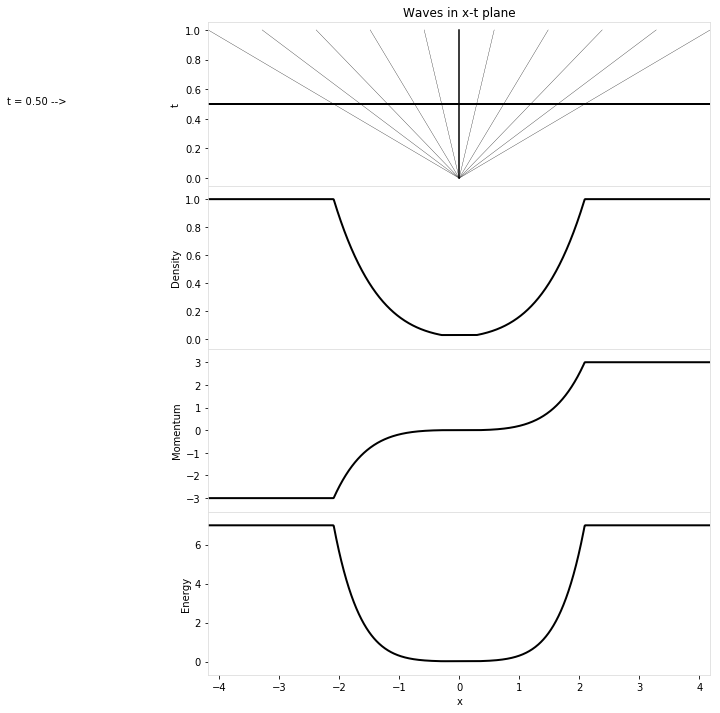

In [10]:
%matplotlib inline
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
plot_function = riemann_tools.make_plot_function(ex_states, ex_speeds, reval, 
                                                     layout='vertical', conserved_variables=varsout)
interact(plot_function, t=widgets.FloatSlider(value=0.0,min=0,max=1.0))

Now we need to iterate this function using a Newton method, to find which value of $p_*$ yields $\Phi(p_*)=0$

We just obtained the pressure and velocity middle states $p_*$ and $u_*$ that are continuous across the contact disconitnuity and the middle states for the density $\rho_{*L}$ and $\rho_{*R}$ have also been obtained from the function and saved as global variables. We also know the speed the left and right waves are traveling. We can now plot the solution to the Riemann problem. 